In [26]:
pip install pandas matplotlib openpyxl fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=5484310726905c7ae5b6d5280066fedf5d346f49344d4b92cef3d5001b180ea2
  Stored in directory: /Users/lasyatummala/Library/Caches/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn.ensemble import IsolationForest
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from fpdf import FPDF
import random
from datetime import datetime, timedelta


In [3]:

# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"  # Replace with your file path if different
mock_dataset = pd.read_csv(file_path)

# Step 1: Check and handle missing values
# Display missing values count
missing_values = mock_dataset.isnull().sum()

# Step 2: Remove duplicates
mock_dataset_cleaned = mock_dataset.drop_duplicates()

# Step 3: Validate data types and ranges
# Ensure 'Timestamp' is in datetime format
mock_dataset_cleaned['Timestamp'] = pd.to_datetime(mock_dataset_cleaned['Timestamp'], errors='coerce')

# Remove rows with invalid timestamps
mock_dataset_cleaned = mock_dataset_cleaned[mock_dataset_cleaned['Timestamp'].notnull()]

# Validate 'Value' based on sensor type
for sensor_type in ["Fire Alarm", "Temperature Sensor", "Motion Sensor"]:
    if sensor_type == "Fire Alarm":
        # Fire Alarm values should be 0 or 1
        mock_dataset_cleaned = mock_dataset_cleaned[
            (mock_dataset_cleaned['Sensor Type'] != "Fire Alarm") | (mock_dataset_cleaned['Value'].isin([0, 1]))
        ]
    elif sensor_type == "Temperature Sensor":
        # Temperature Sensor values should be between 20 and 100
        mock_dataset_cleaned = mock_dataset_cleaned[
            (mock_dataset_cleaned['Sensor Type'] != "Temperature Sensor") | 
            ((mock_dataset_cleaned['Value'] >= 20) & (mock_dataset_cleaned['Value'] <= 100))
        ]
    elif sensor_type == "Motion Sensor":
        # Motion Sensor values should be between 0 and 10
        mock_dataset_cleaned = mock_dataset_cleaned[
            (mock_dataset_cleaned['Sensor Type'] != "Motion Sensor") | 
            ((mock_dataset_cleaned['Value'] >= 0) & (mock_dataset_cleaned['Value'] <= 10))
        ]

# Save the cleaned dataset
cleaned_file_path = "smart_building_cleaned_data_500.csv"
mock_dataset_cleaned.to_csv(cleaned_file_path, index=False)

# Display summary of cleaning
print("Cleaning Summary:")
print(f"Missing Values (Before Cleaning):\n{missing_values}")
print(f"Duplicates Removed: {mock_dataset.shape[0] - mock_dataset_cleaned.shape[0]}")
print(f"Cleaned dataset saved to: {cleaned_file_path}")


Cleaning Summary:
Missing Values (Before Cleaning):
Sensor ID       0
Sensor Type     0
Location        0
Timestamp       0
Value          52
Risk Level      0
dtype: int64
Duplicates Removed: 97
Cleaned dataset saved to: smart_building_cleaned_data_500.csv


/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_33816/3510079410.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mock_dataset_cleaned['Timestamp'] = pd.to_datetime(mock_dataset_cleaned['Timestamp'], errors='coerce')


In [4]:
import pandas as pd

# Load the dataset with issues
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"
mock_dataset_with_issues = pd.read_csv(file_path)

# Function to identify outliers
def identify_outliers(df):
    outliers = []
    for index, row in df.iterrows():
        sensor_type = row['Sensor Type']
        value = row['Value']
        
        if pd.isnull(value):  # Skip missing values
            continue
        
        # Check for outliers based on sensor type
        if sensor_type == "Fire Alarm" and value not in [0, 1]:
            outliers.append(index)
        elif sensor_type == "Temperature Sensor" and (value < 20 or value > 100):
            outliers.append(index)
        elif sensor_type == "Motion Sensor" and (value < 0 or value > 10):
            outliers.append(index)
    
    return outliers

# Identify outliers
outlier_indices = identify_outliers(mock_dataset_with_issues)

# Print the indices and details of the outliers
outlier_data = mock_dataset_with_issues.loc[outlier_indices]
print("Outliers Detected:")
print(outlier_data)

# Optionally save the outlier data to a file
outliers_file_path = "/Users/lasyatummala/Downloads/smart_building_outliers.csv"
outlier_data.to_csv(outliers_file_path, index=False)
print(f"Outliers saved to: {outliers_file_path}")



Outliers Detected:
    Sensor ID         Sensor Type Location            Timestamp  Value  \
12         S5  Temperature Sensor  Room C2  2025-01-04 11:28:32  150.0   
48        S47          Fire Alarm  Room A2  2025-01-02 11:14:31    2.0   
74        S29  Temperature Sensor  Room C2  2025-01-07 16:20:29  150.0   
78        S48  Temperature Sensor  Room A4  2025-01-06 14:48:04  150.0   
89        S48       Motion Sensor  Room A1  2025-01-04 04:24:13   -5.0   
232       S48  Temperature Sensor  Room A5  2025-01-05 10:47:16  150.0   
249       S31  Temperature Sensor  Room C1  2025-01-02 21:07:36  150.0   
281       S46       Motion Sensor  Room B3  2025-01-02 03:17:13   -5.0   
309       S17       Motion Sensor  Room A1  2025-01-07 10:13:15   -5.0   
318        S2  Temperature Sensor  Room C4  2025-01-06 17:33:12  150.0   
355        S7          Fire Alarm  Room B2  2025-01-04 01:10:24    2.0   
370       S13       Motion Sensor  Room A3  2025-01-03 08:33:02   -5.0   
402        S9      

In [5]:

# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"
mock_dataset = pd.read_csv(file_path)

# 1. Basic Dataset Information
print("Dataset Overview:")
print(mock_dataset.info())  # Column types and non-null counts
print("\nFirst Few Rows:")
print(mock_dataset.head())  # Preview data



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sensor ID    530 non-null    object 
 1   Sensor Type  530 non-null    object 
 2   Location     530 non-null    object 
 3   Timestamp    530 non-null    object 
 4   Value        478 non-null    float64
 5   Risk Level   530 non-null    object 
dtypes: float64(1), object(5)
memory usage: 25.0+ KB
None

First Few Rows:
  Sensor ID         Sensor Type Location            Timestamp  Value  \
0       S44       Motion Sensor  Room A5  2025-01-07 23:33:24    5.0   
1        S1       Motion Sensor  Room C1  2025-01-04 22:11:30    0.0   
2        S9  Temperature Sensor  Room C5  2025-01-01 05:24:13   51.8   
3       S36          Fire Alarm  Room B2  2025-01-07 19:45:07    1.0   
4        S7  Temperature Sensor  Room B1  2025-01-07 11:27:25   43.7   

  Risk Level  
0        Low  
1   

In [6]:
# 2. Descriptive Statistics
print("\nDescriptive Statistics:")
print(mock_dataset.describe(include='all'))  # Summary statistics for numerical and categorical columns




Descriptive Statistics:
       Sensor ID    Sensor Type Location            Timestamp       Value  \
count        530            530      530                  530  478.000000   
unique        50              3       15                  500         NaN   
top           S9  Motion Sensor  Room A4  2025-01-05 09:56:28         NaN   
freq          19            188       46                    2         NaN   
mean         NaN            NaN      NaN                  NaN   24.206067   
std          NaN            NaN      NaN                  NaN   34.577558   
min          NaN            NaN      NaN                  NaN   -5.000000   
25%          NaN            NaN      NaN                  NaN    1.000000   
50%          NaN            NaN      NaN                  NaN    5.000000   
75%          NaN            NaN      NaN                  NaN   46.600000   
max          NaN            NaN      NaN                  NaN  150.000000   

       Risk Level  
count         530  
unique    


Sensor Type Distribution:
Motion Sensor         188
Temperature Sensor    178
Fire Alarm            164
Name: Sensor Type, dtype: int64


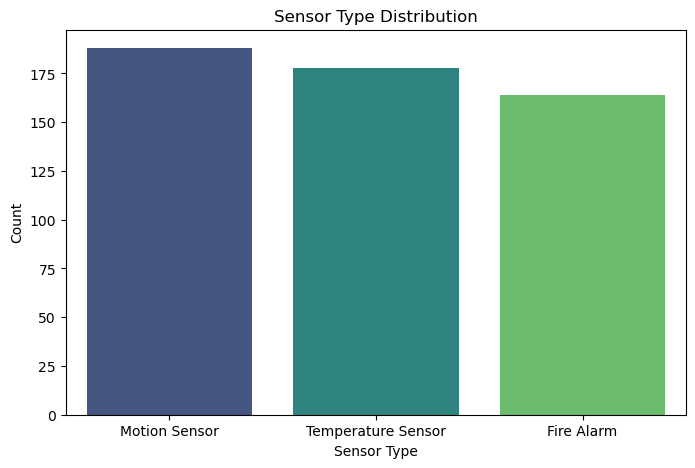

In [7]:
# 3. Sensor Type Distribution
sensor_type_counts = mock_dataset['Sensor Type'].value_counts()
print("\nSensor Type Distribution:")
print(sensor_type_counts)

# Plot Sensor Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=mock_dataset, x='Sensor Type', palette='viridis')
plt.title('Sensor Type Distribution')
plt.xlabel('Sensor Type')
plt.ylabel('Count')
plt.show()




Risk Level Distribution:
Low       318
High      194
Medium     18
Name: Risk Level, dtype: int64


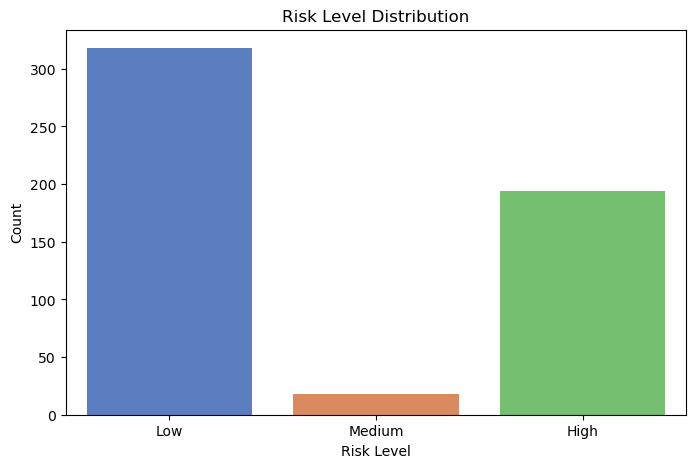

In [8]:
# 4. Risk Level Analysis
risk_level_counts = mock_dataset['Risk Level'].value_counts()
print("\nRisk Level Distribution:")
print(risk_level_counts)

# Plot Risk Level Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=mock_dataset, x='Risk Level', palette='muted')
plt.title('Risk Level Distribution')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()




Daily Sensor Readings:
Date
2025-01-01    59
2025-01-02    62
2025-01-03    77
2025-01-04    79
2025-01-05    81
2025-01-06    89
2025-01-07    83
dtype: int64


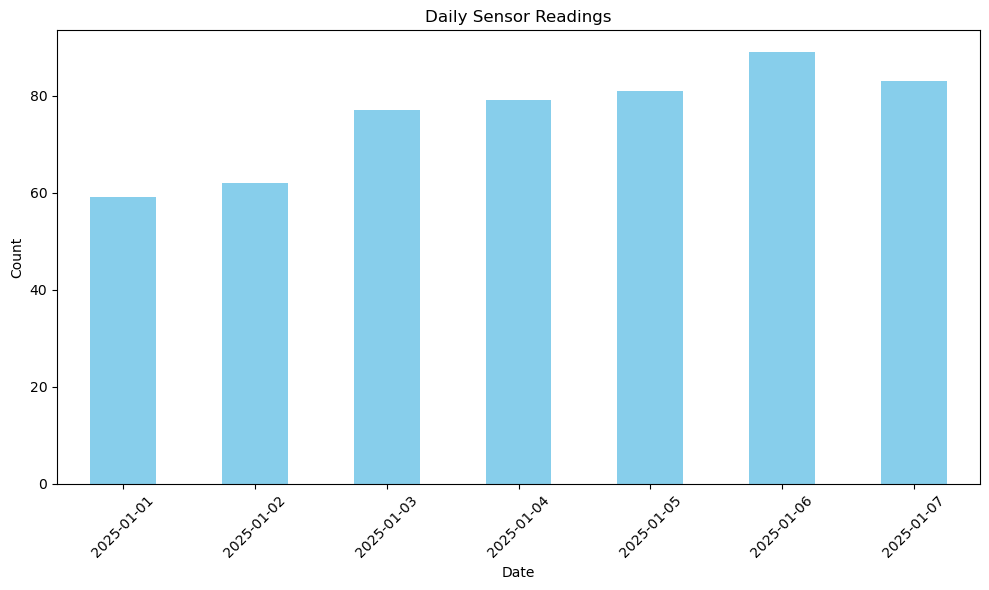

In [9]:
# 5. Timestamp Analysis
mock_dataset['Timestamp'] = pd.to_datetime(mock_dataset['Timestamp'], errors='coerce')
mock_dataset['Date'] = mock_dataset['Timestamp'].dt.date

# Daily Sensor Readings
daily_counts = mock_dataset.groupby('Date').size()
print("\nDaily Sensor Readings:")
print(daily_counts)

# Plot Daily Sensor Readings
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.title('Daily Sensor Readings')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



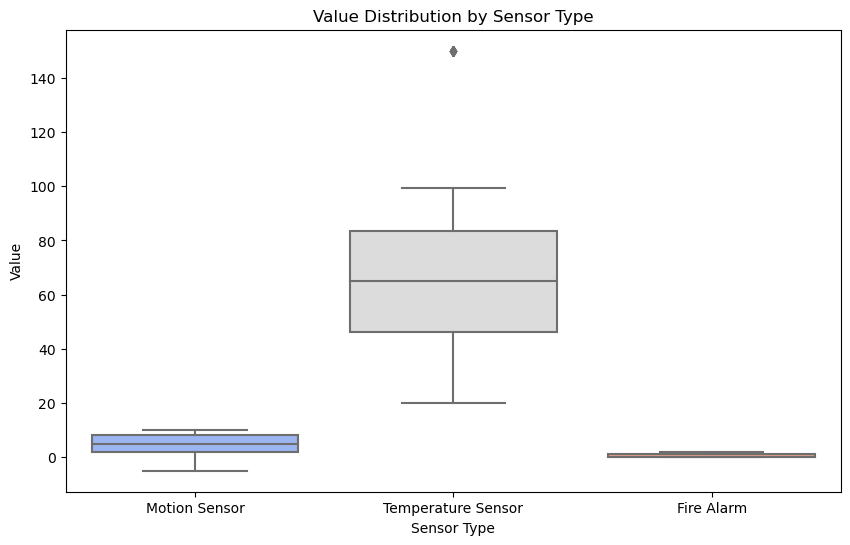

In [10]:
# 6. Value Analysis per Sensor Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=mock_dataset, x='Sensor Type', y='Value', palette='coolwarm')
plt.title('Value Distribution by Sensor Type')
plt.xlabel('Sensor Type')
plt.ylabel('Value')
plt.show()



In [11]:
# 7. Outliers Detection
# Highlight potential outliers using IQR for each sensor type
print("\nPotential Outliers by Sensor Type:")
for sensor_type in mock_dataset['Sensor Type'].unique():
    subset = mock_dataset[mock_dataset['Sensor Type'] == sensor_type]
    Q1 = subset['Value'].quantile(0.25)
    Q3 = subset['Value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = subset[(subset['Value'] < lower_bound) | (subset['Value'] > upper_bound)]
    print(f"\n{sensor_type} Outliers:")
    print(outliers)

# Save a summary report
report_file = "/Users/lasyatummala/Downloads/smart_building_analysis_summary.csv"
summary = {
    "Sensor Type Counts": sensor_type_counts,
    "Risk Level Counts": risk_level_counts,
    "Daily Counts": daily_counts,
}
summary_df = pd.concat(
    [pd.DataFrame(summary["Sensor Type Counts"]), pd.DataFrame(summary["Risk Level Counts"])],
    axis=1,
)
summary_df.to_csv(report_file)
print(f"\nAnalysis summary saved to: {report_file}")



Potential Outliers by Sensor Type:

Motion Sensor Outliers:
Empty DataFrame
Columns: [Sensor ID, Sensor Type, Location, Timestamp, Value, Risk Level, Date]
Index: []

Temperature Sensor Outliers:
    Sensor ID         Sensor Type Location           Timestamp  Value  \
12         S5  Temperature Sensor  Room C2 2025-01-04 11:28:32  150.0   
74        S29  Temperature Sensor  Room C2 2025-01-07 16:20:29  150.0   
78        S48  Temperature Sensor  Room A4 2025-01-06 14:48:04  150.0   
232       S48  Temperature Sensor  Room A5 2025-01-05 10:47:16  150.0   
249       S31  Temperature Sensor  Room C1 2025-01-02 21:07:36  150.0   
318        S2  Temperature Sensor  Room C4 2025-01-06 17:33:12  150.0   
434       S34  Temperature Sensor  Room A1 2025-01-02 02:50:30  150.0   
445        S7  Temperature Sensor  Room A2 2025-01-03 17:16:47  150.0   

    Risk Level        Date  
12        High  2025-01-04  
74        High  2025-01-07  
78         Low  2025-01-06  
232       High  2025-01-05  


Correlation Matrix:
                       Value  Risk Level Numeric
Value               1.000000            0.543611
Risk Level Numeric  0.543611            1.000000


/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_33816/3100027956.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mock_dataset_numeric['Risk Level Numeric'] = mock_dataset_numeric['Risk Level'].map({'Low': 0, 'Medium': 1, 'High': 2})


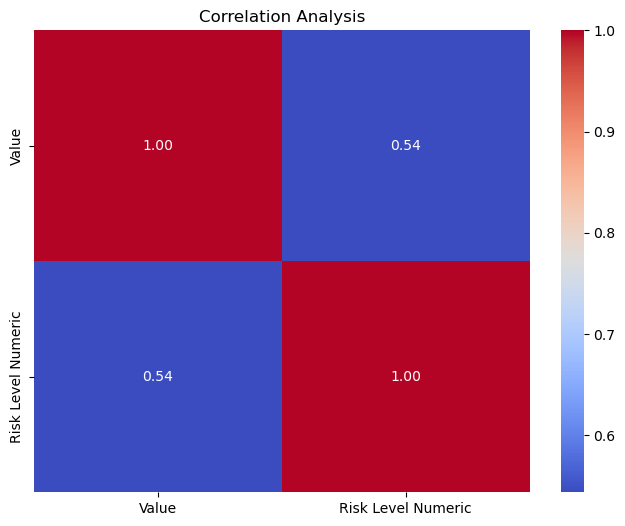

In [12]:

# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"    # Update with your file path if needed
mock_dataset_with_issues = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
mock_dataset_with_issues['Value'] = pd.to_numeric(mock_dataset_with_issues['Value'], errors='coerce')

# Drop rows with missing or invalid 'Value'
mock_dataset_numeric = mock_dataset_with_issues.dropna(subset=['Value'])

# Create a column to encode 'Risk Level' as numeric
mock_dataset_numeric['Risk Level Numeric'] = mock_dataset_numeric['Risk Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Calculate correlation matrix
correlation_results = mock_dataset_numeric[['Value', 'Risk Level Numeric']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_results)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis")
plt.show()


In [13]:

# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"  # Update with your file path if needed
mock_dataset = pd.read_csv(file_path)

# Data Preparation
# Convert 'Value' to numeric and drop rows with missing or invalid values
mock_dataset['Value'] = pd.to_numeric(mock_dataset['Value'], errors='coerce')
mock_dataset = mock_dataset.dropna(subset=['Value'])

# Encode 'Risk Level' as numeric
mock_dataset['Risk Level'] = mock_dataset['Risk Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Encode 'Sensor Type' as numeric
mock_dataset['Sensor Type'] = mock_dataset['Sensor Type'].astype('category').cat.codes

# Define features (X) and target (y)
X = mock_dataset[['Sensor Type', 'Value']]
y = mock_dataset['Risk Level']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        61
           1       1.00      1.00      1.00         3
           2       0.97      1.00      0.98        32

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96



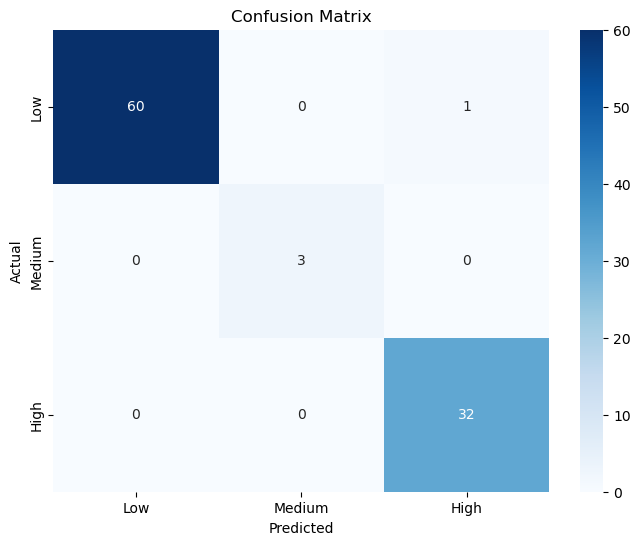

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




Feature Importance:
Value          0.793239
Sensor Type    0.206761
dtype: float64


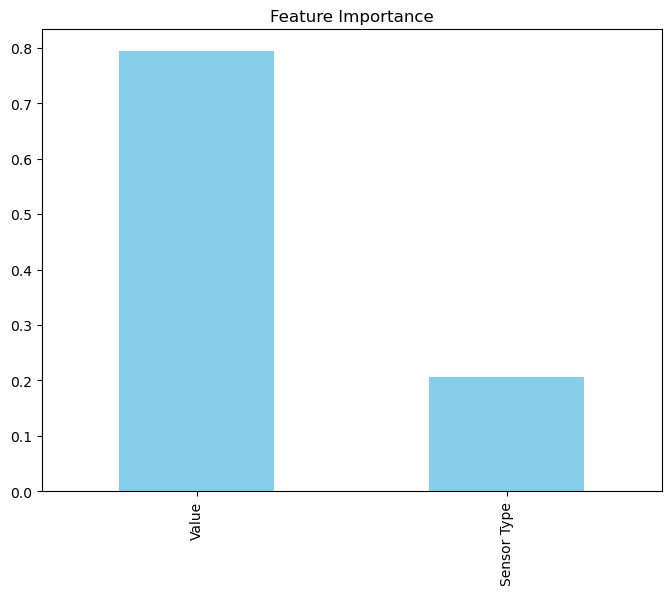

In [15]:
# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title("Feature Importance")
plt.show()


In [16]:


# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"  # Replace with your file path
mock_dataset = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
mock_dataset['Value'] = pd.to_numeric(mock_dataset['Value'], errors='coerce')

# Drop rows with missing or invalid 'Value'
mock_dataset = mock_dataset.dropna(subset=['Value'])

# Encode 'Risk Level' as numeric
mock_dataset['Risk Level'] = mock_dataset['Risk Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Real-time streaming simulation
def process_sensor_data(row):
    sensor_id = row['Sensor ID']
    sensor_type = row['Sensor Type']
    value = row['Value']
    risk_level = row['Risk Level']
    timestamp = row['Timestamp']
    
    # Simple analysis: Trigger alert for high risk
    if risk_level == 2:  # High Risk
        print(f"[ALERT] High risk detected! Sensor ID: {sensor_id}, Type: {sensor_type}, Value: {value}, Timestamp: {timestamp}")
    else:
        print(f"Processing Sensor ID: {sensor_id}, Risk Level: {risk_level}, Timestamp: {timestamp}")

# Simulate real-time streaming
for _, row in mock_dataset.iterrows():
    process_sensor_data(row)
    time.sleep(0.5)  # Simulate delay between data rows


Processing Sensor ID: S44, Risk Level: 0, Timestamp: 2025-01-07 23:33:24
Processing Sensor ID: S1, Risk Level: 1, Timestamp: 2025-01-04 22:11:30
[ALERT] High risk detected! Sensor ID: S9, Type: Temperature Sensor, Value: 51.8, Timestamp: 2025-01-01 05:24:13
[ALERT] High risk detected! Sensor ID: S36, Type: Fire Alarm, Value: 1.0, Timestamp: 2025-01-07 19:45:07
Processing Sensor ID: S7, Risk Level: 0, Timestamp: 2025-01-07 11:27:25
Processing Sensor ID: S16, Risk Level: 0, Timestamp: 2025-01-06 14:27:45
[ALERT] High risk detected! Sensor ID: S41, Type: Temperature Sensor, Value: 80.8, Timestamp: 2025-01-05 13:15:04
Processing Sensor ID: S4, Risk Level: 0, Timestamp: 2025-01-05 05:29:27
Processing Sensor ID: S23, Risk Level: 0, Timestamp: 2025-01-02 13:31:48
[ALERT] High risk detected! Sensor ID: S30, Type: Fire Alarm, Value: 1.0, Timestamp: 2025-01-06 14:45:27
Processing Sensor ID: S10, Risk Level: 0, Timestamp: 2025-01-04 11:37:33
[ALERT] High risk detected! Sensor ID: S5, Type: Temper

In [18]:

# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"
mock_dataset = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
mock_dataset['Value'] = pd.to_numeric(mock_dataset['Value'], errors='coerce')

# Drop rows with missing or invalid 'Value'
mock_dataset = mock_dataset.dropna(subset=['Value'])

# Add mock latitude and longitude for sensors (for demonstration purposes)
import random
mock_dataset['Latitude'] = [random.uniform(37.7749, 37.7849) for _ in range(len(mock_dataset))]
mock_dataset['Longitude'] = [random.uniform(-122.4194, -122.4094) for _ in range(len(mock_dataset))]

# Encode 'Risk Level' as numeric for weighting
mock_dataset['Risk Level'] = mock_dataset['Risk Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Create a base map centered around the mock location
map_center = [37.7799, -122.4149]  # Approximate center of the mock data
risk_map = folium.Map(location=map_center, zoom_start=15)

# Add markers for each sensor
for _, row in mock_dataset.iterrows():
    color = 'green' if row['Risk Level'] == 0 else 'orange' if row['Risk Level'] == 1 else 'red'
    popup_info = f"Sensor ID: {row['Sensor ID']}<br>Risk Level: {row['Risk Level']}<br>Value: {row['Value']}"
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=popup_info
    ).add_to(risk_map)

# Add a heatmap to visualize high-risk areas
heat_data = mock_dataset[mock_dataset['Risk Level'] > 0][['Latitude', 'Longitude', 'Risk Level']].values.tolist()
HeatMap(heat_data, radius=15).add_to(risk_map)

# Save the map as an HTML file
output_file = "/Users/lasyatummala/Downloads/geographic_risk_map.html"
risk_map.save(output_file)

print(f"Geographic Risk Map saved to: {output_file}")


Geographic Risk Map saved to: /Users/lasyatummala/Downloads/geographic_risk_map.html


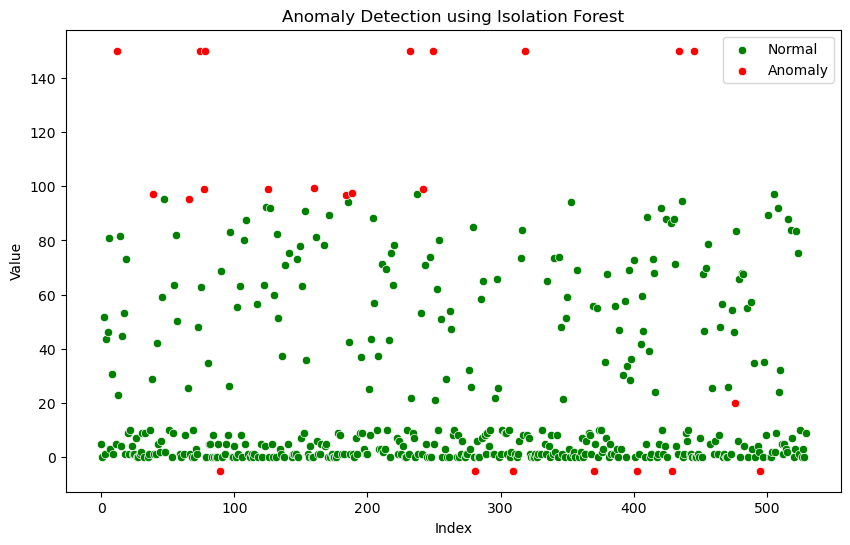

Detected Anomalies:
    Sensor ID         Sensor Type Location            Timestamp  Value  \
12         S5  Temperature Sensor  Room C2  2025-01-04 11:28:32  150.0   
39        S30  Temperature Sensor  Room C5  2025-01-04 18:17:10   97.2   
66         S5  Temperature Sensor  Room C1  2025-01-04 20:02:03   95.2   
74        S29  Temperature Sensor  Room C2  2025-01-07 16:20:29  150.0   
77        S18  Temperature Sensor  Room C5  2025-01-06 18:21:22   99.1   
78        S48  Temperature Sensor  Room A4  2025-01-06 14:48:04  150.0   
89        S48       Motion Sensor  Room A1  2025-01-04 04:24:13   -5.0   
125       S19  Temperature Sensor  Room A2  2025-01-03 05:31:49   98.9   
160       S36  Temperature Sensor  Room C1  2025-01-03 01:18:03   99.4   
184       S47  Temperature Sensor  Room C5  2025-01-04 20:20:08   96.8   
188        S4  Temperature Sensor  Room A1  2025-01-02 02:14:03   97.5   
232       S48  Temperature Sensor  Room A5  2025-01-05 10:47:16  150.0   
242       S36  Tem

In [20]:


# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"
mock_dataset = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
mock_dataset['Value'] = pd.to_numeric(mock_dataset['Value'], errors='coerce')

# Drop rows with missing or invalid 'Value'
mock_dataset = mock_dataset.dropna(subset=['Value'])

# Select relevant features for anomaly detection
features = mock_dataset[['Value']]

# Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)  # Assume 5% anomalies
mock_dataset['Anomaly'] = model.fit_predict(features)

# Label anomalies (-1: anomaly, 1: normal)
mock_dataset['Anomaly'] = mock_dataset['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Separate anomalies and normal data
anomalies = mock_dataset[mock_dataset['Anomaly'] == 'Anomaly']
normal_data = mock_dataset[mock_dataset['Anomaly'] == 'Normal']

# Plot results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=normal_data, x=normal_data.index, y='Value', label='Normal', color='green')
sns.scatterplot(data=anomalies, x=anomalies.index, y='Value', label='Anomaly', color='red')
plt.title("Anomaly Detection using Isolation Forest")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

# Display anomalies
print("Detected Anomalies:")
print(anomalies)


In [21]:
mock_dataset['Z-Score'] = (mock_dataset['Value'] - mock_dataset['Value'].mean()) / mock_dataset['Value'].std()
mock_dataset['Anomaly'] = mock_dataset['Z-Score'].abs() > 3


In [23]:

# Function to send an alert
def send_email_alert(sensor_id, value, timestamp):
    sender_email = "your_email@example.com"
    receiver_email = "recipient_email@example.com"
    password = "your_password"

    # Email content
    subject = f"ALERT: Anomaly Detected for Sensor {sensor_id}"
    body = f"""
    An anomaly has been detected!
    Sensor ID: {sensor_id}
    Value: {value}
    Timestamp: {timestamp}
    Please take immediate action.
    """
    
    # Set up the email
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        # Connect to the email server
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
        print(f"Email alert sent for Sensor ID: {sensor_id}")
    except Exception as e:
        print(f"Failed to send email: {e}")

# Trigger alerts for anomalies
for _, row in anomalies.iterrows():
    send_email_alert(row['Sensor ID'], row['Value'], row['Timestamp'])


Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-21c2d3e088bsm67800665ad.173 - gsmtp')
Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-21c2d3ac64csm69274845ad.149 - gsmtp')
Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d2e1a72fcca58-72daba48cd0sm8066945b3a.131 - gsmtp')
Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-21c2d426a3asm68589745ad.249 - gsmtp')
Failed to send email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9

In [24]:


# Add mock latitude and longitude for anomalies (for demonstration purposes)
import random
anomalies['Latitude'] = [random.uniform(37.7749, 37.7849) for _ in range(len(anomalies))]
anomalies['Longitude'] = [random.uniform(-122.4194, -122.4094) for _ in range(len(anomalies))]

# Create a base map
map_center = [37.7799, -122.4149]  # Approximate center of the mock data
anomaly_map = folium.Map(location=map_center, zoom_start=15)

# Add markers for anomalies
for _, row in anomalies.iterrows():
    popup_info = f"Sensor ID: {row['Sensor ID']}<br>Value: {row['Value']}<br>Timestamp: {row['Timestamp']}"
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=popup_info
    ).add_to(anomaly_map)

# Save the anomaly map as an HTML file
output_file = "/Users/lasyatummala/Downloads/anomaly_map.html"
anomaly_map.save(output_file)

print(f"Anomaly map saved to: {output_file}")


Anomaly map saved to: /Users/lasyatummala/Downloads/anomaly_map.html


/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_33816/563816853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Latitude'] = [random.uniform(37.7749, 37.7849) for _ in range(len(anomalies))]
/var/folders/fp/drm5pw1d13x1n4wvd2q14v0m0000gn/T/ipykernel_33816/563816853.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Longitude'] = [random.uniform(-122.4194, -122.4094) for _ in range(len(anomalies))]


In [28]:


# Load the dataset
file_path = "/Users/lasyatummala/Downloads/smart_building_mock_data_with_issues.csv"
mock_dataset = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
mock_dataset['Value'] = pd.to_numeric(mock_dataset['Value'], errors='coerce')
mock_dataset = mock_dataset.dropna(subset=['Value'])

# Convert 'Timestamp' to datetime format
mock_dataset['Timestamp'] = pd.to_datetime(mock_dataset['Timestamp'], errors='coerce')
mock_dataset['Date'] = mock_dataset['Timestamp'].dt.date

# Weekly Summary
weekly_summary = mock_dataset.groupby(pd.Grouper(key='Timestamp', freq='W')).agg(
    total_readings=('Sensor ID', 'count'),
    avg_value=('Value', 'mean'),
    max_value=('Value', 'max'),
    high_risk_count=('Risk Level', lambda x: (x == 'High').sum())
).reset_index()

# Risk Level Distribution
risk_distribution = mock_dataset['Risk Level'].value_counts()

# Save Weekly Summary to Excel
excel_file = "/Users/lasyatummala/Downloads/sensor_activity_report.xlsx"
weekly_summary.to_excel(excel_file, index=False)
print(f"Weekly report saved to: {excel_file}")

# Generate PDF Report
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

# PDF Header
pdf.set_font("Arial", style='B', size=14)
pdf.cell(200, 10, txt="Sensor Activity Report", ln=True, align='C')
pdf.ln(10)

# Add Weekly Summary to PDF
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, txt="Weekly Summary:", ln=True)
for _, row in weekly_summary.iterrows():
    line = f"Week Ending {row['Timestamp'].date()} | Total Readings: {row['total_readings']} | Avg Value: {row['avg_value']:.2f} | Max Value: {row['max_value']:.2f} | High Risk: {row['high_risk_count']}"
    pdf.cell(200, 10, txt=line, ln=True)

# Add Risk Distribution Chart to PDF
plt.figure(figsize=(8, 5))
risk_distribution.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.savefig("/Users/lasyatummala/Downloads/risk_distribution.png")
plt.close()

pdf.add_page()
pdf.cell(200, 10, txt="Risk Level Distribution", ln=True)
pdf.image("/Users/lasyatummala/Downloads/risk_distribution.png", x=10, y=30, w=180)

# Save PDF Report
pdf_file = "/Users/lasyatummala/Downloads/sensor_activity_report.pdf"
pdf.output(pdf_file)
print(f"PDF report saved to: {pdf_file}")


Weekly report saved to: /Users/lasyatummala/Downloads/sensor_activity_report.xlsx
PDF report saved to: /Users/lasyatummala/Downloads/sensor_activity_report.pdf
